In [1]:
import pandas as pd
import csv
import numpy as np
from numpy import array
from numpy import argmax
from sklearn.preprocessing import LabelEncoder
from techniques1 import *
from nltk.stem.porter import *
from nltk.stem.wordnet import WordNetLemmatizer

In [2]:
def readfile(filename):
    
    arr=[]
    with open(filename,'rt',encoding='latin-1') as file:     
                samples=csv.reader(file)
                x=0
                for i in samples:
                    if x==0:
                        x=1
                        continue
                    arr.append(i)
    df=pd.DataFrame(data=arr,columns=["types","posts"])
    return df

In [3]:
def labelencode(df):
    data=df['types']
    values=array(data)
    label=LabelEncoder()
    intencode=label.fit_transform(values)
    df['typeint']=intencode
    #df['typeint'].plot(kind='hist')
    #k=np.arange(0,16)
    #x=label.inverse_transform(k)   #can access encoded actual value using x
    #print(values)
    return df


In [4]:
def createSlangframe():
    f="slang.txt"
    a=[]
    with open(f,'rt',encoding='latin-1') as file:     
                samples=csv.reader(file,delimiter='\t')
                x=0
                for i in samples:
                    if x==0:
                        x=1
                        continue
                    a.append(i)
    slangframe=pd.DataFrame(data=a,columns=['slang','fullform'])
    return slangframe


In [5]:
def preprocess(shortdata,slangframe):
    slang=list(slangframe['slang'])
    for i in range(len(shortdata)):
        #counts emojis and remove
        shortdata.loc[i,'emojicount']=countEmoticons(shortdata['posts'][i])
        shortdata.loc[i,'posts']=removeEmoticons(shortdata['posts'][i])
        #counts slang and removes
        shortdata.loc[i,'slangcount']=countSlang(shortdata['posts'][i])
        q=shortdata['posts'][i].split()
        for j in range(len(q)):
            if q[j] in slang:
                q[j]=slangframe['fullform'][slang.index(q[j])]
        shortdata.loc[i,'posts']=' '.join(q)
        #replaces contractions with full forms
        shortdata.loc[i,'posts']=replaceContraction(shortdata['posts'][i])
        #counts urls and replaces
        shortdata.loc[i,'urlcount']=countURL(shortdata['posts'][i])
        shortdata.loc[i,'posts']=replaceurl(shortdata['posts'][i]) 
        #counts #()-() and @-atuser and removes them
        shortdata.loc[i,'#_@count']=counthashAt(shortdata['posts'][i])
        shortdata.loc[i,'posts']=replaceAtUser(shortdata['posts'][i])
        shortdata.loc[i,'posts']=removeHashtagInFrontOfWord(shortdata['posts'][i])
        #puctuations clearing
        punct=clear_punctuation(shortdata['posts'][i])
        shortdata.loc[i,'posts']=punct[0]
        shortdata.loc[i,'punct_count']=punct[1]
        #replaces negations
        shortdata.loc[i,'posts']=replaceNegations(shortdata['posts'][i]) 
        #remove unicodes
        shortdata.loc[i,'posts']=removeUnicode(shortdata['posts'][i]) 
        #removes numbers
        shortdata.loc[i,'posts']=removeNumbers(shortdata['posts'][i])
        #remove stopwords
    from nltk.corpus import stopwords
    stop=stopwords.words("english")
    my_stopwords = "multiexclamation multiquestion multistop url atuser st rd nd th am pm httpurl httpsurl http" # my extra stopwords
    stop = stop + my_stopwords.split()
    shortdata['posts']=shortdata['posts'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
    ps = PorterStemmer()
    shortdata['posts'] = shortdata['posts'].apply(lambda x: ' '.join([ps.stem(word) for word in x.split() ]))
    lmtzr = WordNetLemmatizer()
    shortdata['posts'] = shortdata['posts'].apply(lambda x: ' '.join([lmtzr.lemmatize(word,'v') for word in x.split() ]))
    #spell correction
    """for i in range(len(shortdata)):
        q=shortdata.loc[i,'posts'].split()
        for j in range(len(q)):
            q[j]=spellCorrection(q[j])
        shortdata.loc[i,'posts']=' '.join(q)"""
    return shortdata



In [7]:
def call_clean():
    filename="mbti_1.csv"
    df=readfile(filename)
    df=labelencode(df)
    slangframe=createSlangframe()
    clean_data=preprocess(df,slangframe)
    print(clean_data.head())
    return clean_data
data=call_clean()

  types                                              posts  typeint  \
0  INFJ  intj moment http sportscent top ten play http ...        8   
1  ENTP  Im find lack post alarmingsex bore posit often...        3   
2  INTP  good one http cours I say I know bless cursedo...       11   
3  INTJ  dear intp I enjoy convers day esoter gab natur...       10   
4  ENTJ  you firedthat anoth silli misconcept that appr...        2   

   emojicount  slangcount  urlcount  #_@count  punct_count  
0        34.0         2.0      14.0       0.0        291.0  
1        29.0         1.0       1.0       0.0        458.0  
2        19.0         0.0       4.0       0.0        339.0  
3         6.0         2.0       2.0       0.0        398.0  
4        16.0         6.0       2.0       2.0        354.0  


In [8]:
proc_data=data

In [9]:
proc_data=np.array(data['posts'])
label=np.array(data['typeint'])


(array([ 152.,  540.,  185.,  548.,   34.,   38.,   31.,   71., 1176.,
        1465.,  873., 1043.,  133.,  217.,  434.]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15]),
 <a list of 15 Patch objects>)

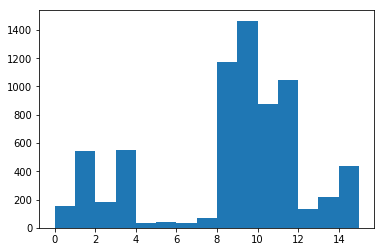

In [59]:
from sklearn.model_selection import train_test_split
trainset, testset, trainlabel, testlabel = train_test_split(proc_data, label,stratify=label, test_size=0.2)
import matplotlib as plt
from matplotlib import pyplot
#plt.plot(x)
pyplot.hist(trainlabel,np.arange(0,16))


In [60]:
print(trainlabel.shape)

(6940,)


In [13]:
sentences=[]
for line in trainset:
    sentences.append(line.split())
from gensim.models import Word2Vec
modelw2v=Word2Vec(sentences, size=100, window=5, min_count=2, workers=4)
print(modelw2v)
words=list(modelw2v.wv.vocab)

Word2Vec(vocab=58341, size=100, alpha=0.025)


In [14]:
import bokeh.plotting as bp
from bokeh.models import HoverTool, BoxSelectTool
from bokeh.plotting import figure, show, output_notebook

# defining the chart
output_notebook()
plot_tfidf = bp.figure(plot_width=700, plot_height=600, title="A map of 10000 word vectors",
    tools="pan,wheel_zoom,box_zoom,reset,hover,previewsave",
    x_axis_type=None, y_axis_type=None, min_border=1)

# getting a list of word vectors. limit to 10000. each is of 200 dimensions
word_vectors = [modelw2v[w] for w in list(modelw2v.wv.vocab.keys())]

# dimensionality reduction. converting the vectors to 2d vectors
from sklearn.manifold import TSNE
tsne_model = TSNE(n_components=2, verbose=1, random_state=0)
tsne_w2v = tsne_model.fit_transform(word_vectors)

# putting everything in a dataframe
tsne_df = pd.DataFrame(tsne_w2v, columns=['x', 'y'])
tsne_df['words'] = list(modelw2v.wv.vocab.keys())

Loading BokehJS ...

/home/nikitha/.local/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if sys.path[0] == '':


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 58341 samples in 0.400s...
[t-SNE] Computed neighbors for 58341 samples in 882.950s...
[t-SNE] Computed conditional probabilities for sample 1000 / 58341
[t-SNE] Computed conditional probabilities for sample 2000 / 58341
[t-SNE] Computed conditional probabilities for sample 3000 / 58341
[t-SNE] Computed conditional probabilities for sample 4000 / 58341
[t-SNE] Computed conditional probabilities for sample 5000 / 58341
[t-SNE] Computed conditional probabilities for sample 6000 / 58341
[t-SNE] Computed conditional probabilities for sample 7000 / 58341
[t-SNE] Computed conditional probabilities for sample 8000 / 58341
[t-SNE] Computed conditional probabilities for sample 9000 / 58341
[t-SNE] Computed conditional probabilities for sample 10000 / 58341
[t-SNE] Computed conditional probabilities for sample 11000 / 58341
[t-SNE] Computed conditional probabilities for sample 12000 / 58341
[t-SNE] Computed conditional probabilities for s

In [15]:
# plotting. the corresponding word appears when you hover on the data point.
plot_tfidf.scatter(x='x', y='y', source=tsne_df)
hover = plot_tfidf.select(dict(type=HoverTool))
hover.tooltips={"word": "@words"}
show(plot_tfidf)

In [16]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(analyzer=lambda x: x, min_df=10)
matrix = vectorizer.fit_transform([x.split() for x in trainset])
tfidf = dict(zip(vectorizer.get_feature_names(), vectorizer.idf_))
print('vocab size :', len(tfidf))

vocab size : 14139


In [17]:
def buildWordVector(tokens, size):
    vec = np.zeros(size).reshape((1, size))
    count = 0.
    for word in tokens:
        try:
            vec += modelw2v[word].reshape((1, size)) * tfidf[word]
            count += 1.
        except KeyError: # handling the case where the token is not
                         # in the corpus. useful for testing.
            continue
    if count != 0:
        vec /= count
    return vec

In [61]:
trainset1=[]
for i in trainset:
    a=buildWordVector(i,100)
    trainset1.append(a)

/home/nikitha/.local/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


In [62]:
testset1=[]
for i in testset:
    a=buildWordVector(i,100)
    testset1.append(a)

/home/nikitha/.local/lib/python3.6/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


In [63]:
from numpy import array
trainset1=np.array(trainset1)
testset1=np.array(testset1)

In [65]:
testlabel=np.array(testlabel)
trainlabel=np.array(trainlabel)
print(trainlabel.shape)
print(testlabel.shape)
print(trainset1.shape)
print(testset1.shape)

(6940,)
(1735,)
(6940, 1, 100)
(1735, 1, 100)


In [66]:
trainset1=trainset1.reshape((len(trainset1),100))

testset1=testset1.reshape((len(testset1),100))

In [67]:
np.savetxt("trainset.csv", trainset1, delimiter=",")
np.savetxt("testset.csv", testset1, delimiter=",")
np.savetxt("trainlabel.csv", trainlabel, delimiter=",")
np.savetxt("testlabel.csv", testlabel, delimiter=",")


In [68]:
print(trainset1.shape)
print(trainlabel.shape)
print(testset1.shape)
print(testlabel.shape)

(6940, 100)
(6940,)
(1735, 100)
(1735,)


In [71]:
from sklearn.naive_bayes import GaussianNB
model=GaussianNB()
model.fit(trainset1,trainlabel)
print(model.score(trainset1,trainlabel))
predictionsgnb=model.predict(testset1)
predictionsgnb = model.predict(testset1)
count=0
for i in range(len(predictionsgnb)):
    if predictionsgnb[i]==testlabel[i]:
        count=count+1
print("accuracy=",(count*100)/len(testlabel))

0.16801152737752162
accuracy= 16.080691642651296


In [70]:
from sklearn.model_selection import KFold
from sklearn.neural_network import MLPClassifier
kf = KFold(n_splits=10)
clf = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5, 2), random_state=1)
avg=0
for train_indices, test_indices in kf.split(trainset1):
    clf.fit(trainset1[train_indices], trainlabel[train_indices])
    #print(clf.score(trainset[test_indices], trainlabel[test_indices]))
    prediction=clf.predict(testset1)
    c=0
    for i in range(len(prediction)):
        if prediction[i]==testlabel[i]:
            c=c+1
    res=c*100/len(testlabel)
    avg=avg+res
    print("accuracy=",res)
print("avg accuracy=",avg/10)

accuracy= 25.302593659942364
accuracy= 25.187319884726225
accuracy= 24.956772334293948
accuracy= 25.014409221902017
accuracy= 25.417867435158502
accuracy= 24.956772334293948
accuracy= 25.187319884726225
accuracy= 24.84149855907781
accuracy= 25.072046109510087
accuracy= 25.302593659942364
avg accuracy= 25.12391930835735


In [10]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from nltk.tokenize import word_tokenize

c:\users\nikitha\appdata\local\programs\python\python36\lib\site-packages\gensim\utils.py:1212: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [11]:
tagged_data = [TaggedDocument(words=word_tokenize(_d.lower()), tags=[str(i)]) for i, _d in enumerate(trainset)]
#print(tagged_data)

In [ ]:
max_epochs = 100
vec_size = 20
alpha = 0.025

model = Doc2Vec(size=vec_size,alpha=alpha, min_alpha=0.00025,min_count=1,dm =1)
model.build_vocab(tagged_data)

for epoch in range(max_epochs):
    #print('iteration {0}'.format(epoch))
    model.train(tagged_data,
                total_examples=model.corpus_count,
                epochs=model.iter)
    # decrease the learning rate
    model.alpha -= 0.0002
    # fix the learning rate, no decay
    model.min_alpha = model.alpha

model.save("d2v.model")
print("Model Saved")
print(model)
print(model.docvecs['1'])

c:\users\nikitha\appdata\local\programs\python\python36\lib\site-packages\gensim\models\doc2vec.py:570: UserWarning: The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.
  warnings.warn("The parameter `size` is deprecated, will be removed in 4.0.0, use `vector_size` instead.")
c:\users\nikitha\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).
  if sys.path[0] == '':


In [16]:
train=[]
for i in range(len(trainset)):
    train.append(model.docvecs[i])
trainset=np.array(train) 

[[-0.18914373 -0.20302776  0.00416092 ...  0.18720366  0.22891383
   0.05284937]
 [-0.3249938  -1.1973047   0.7114654  ...  0.8228047   0.62431777
   0.5789972 ]
 [-0.00142897 -0.9997056   0.4400209  ...  0.76707894  0.94090474
   1.0851221 ]
 ...
 [-0.41284165 -0.4688043   0.37761092 ...  0.4504887   0.44820946
   0.33290735]
 [-0.21763164 -0.32383454  0.24509476 ...  0.7357502   0.5944933
   0.48881269]
 [-0.46942854 -0.54872257  0.84596306 ...  0.22824056  0.9934551
   0.40817428]]


In [17]:
from gensim.models.doc2vec import Doc2Vec
test=[]
model= Doc2Vec.load("d2v.model")
#to find the vector of a document which is not in training data
for i in testset:
    test_data = word_tokenize(i.lower())
    test.append(model.infer_vector(test_data))
#print("V1_infer", v1)

# to find most similar doc using tags
#similar_doc = model.docvecs.most_similar('0')
#print(similar_doc)


# to find vector of doc in training data using tags or in other words, printing the vector of document at index 1 in training data
testset=np.array(test)

AttributeError: 'numpy.ndarray' object has no attribute 'lower'

In [72]:
from sklearn.neighbors import KNeighborsClassifier
model=KNeighborsClassifier(n_neighbors=6)
model.fit(trainset1,trainlabel)
print(model.score(trainset1,trainlabel))

predictionsknn = model.predict(testset1)
count=0
for i in range(len(predictionsknn)):
    if predictionsknn[i]==testlabel[i]:
        count=count+1
print("accuracy=",(count*100)/len(testlabel))

0.3984149855907781
accuracy= 18.270893371757925


In [21]:
from sklearn.naive_bayes import GaussianNB
model=GaussianNB()
model.fit(trainset,trainlabel)
print(model.score(trainset,trainlabel))
predictionsgnb=model.predict(testset)
predictionsgnb = model.predict(testset)
count=0
for i in range(len(predictionsgnb)):
    if predictionsgnb[i]==testlabel[i]:
        count=count+1
print("accuracy=",(count*100)/len(testlabel))

0.3527377521613833
accuracy= 17.23342939481268


In [73]:
from sklearn.neural_network import MLPClassifier
model=MLPClassifier()
model.fit(trainset1,trainlabel)
print(model.score(trainset1,trainlabel))
predictionsmlp=model.predict(testset1)
predictionsmlp = model.predict(testset1)
count=0
for i in range(len(predictionsmlp)):
    if predictionsmlp[i]==testlabel[i]:
        count=count+1
print("accuracy=",(count*100)/len(testlabel))

0.25504322766570603
accuracy= 25.244956772334294
